# How the Climate in Melbourne has Changed Over a Century

A strong and longer than usual __[heat wave has hit the  southern states](http://www.smh.com.au/environment/weather/significant-heatwave-roasts-southeastern-australia-as-global-records-melt-20180119-h0l12b.html)__ of Australia so we thought to look into the weather data for Melbourne, it’s second most populous city, to see if there are noteworthy signs of climate change. 

In this notebook we will analyze over 100 years of maximum temperature and precipitation data in Melbourne, Australia using __[Bureau Of Meteorology (BOM) Climate data](http://data.planetos.com/datasets/bom_clim_australia)__.

__[BOM Climate dataset](http://data.planetos.com/datasets/bom_clim_australia)__ contains variables like maximum and minimum temperature, rain and vapour pressure. 


So, we will do the following:

1) use the Planet OS package API to fetch data;

2) see mean annual maximum temperature in Melbourne

3) plot number of days in year when max temperature exceeds 35 $^o$C in Melbourne;

4) find out annual precipitation by year;

5) see if there is more completely dry days than before.



In [1]:
%matplotlib inline
import numpy as np
from dh_py_access import package_api
import dh_py_access.lib.datahub as datahub
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from po_data_process import make_comparison_plot, make_plot, make_anomalies_plot
import requests
import warnings
warnings.filterwarnings("ignore")

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [2]:
server = 'api.planetos.com'
API_key = open('APIKEY').readlines()[0].strip() #'<YOUR API KEY HERE>'
version = 'v1'

At first, we need to define the dataset name and variables we want to use.

In [3]:
dh=datahub.datahub(server,version,API_key)
dataset='bom_clim_australia'
variable_names = 'tmax,tmin,rain'
time_start = '1911-01-01T00:00:00'
time_end = '2017-12-31T00:00:00'
area_name = 'Melbourne'
latitude = -37.81; longitude = 144.98

For starters, using Basemap we created a map of Australia and marked the location of Melbourne city. 

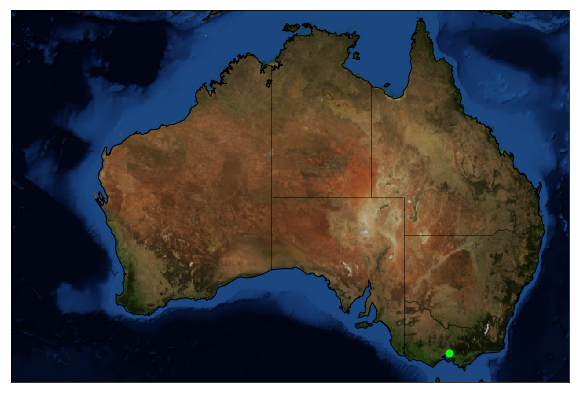

In [4]:
plt.figure(figsize=(10,8))
m = Basemap(projection='merc',llcrnrlat=-39.9,urcrnrlat=-10.,\
            llcrnrlon=105.49,urcrnrlon=155.8,lat_ts=20,resolution='l')
x,y = m(longitude,latitude)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.bluemarble()
m.scatter(x,y,50,marker='o',color='#00FF00',zorder=4)
plt.show()

### Download the data with package API

1. Create package objects
2. Send commands for the package creation
3. Download the package files

_Note that this package has over a 100 years of data and downloading it might take some time_

In [5]:
package = package_api.package_api(dh,dataset,variable_names,longitude,longitude,latitude,latitude,time_start,time_end,area_name=area_name)

In [6]:
package.make_package()

In [7]:
package.download_package()

File already downloaded


## Work with downloaded files

We start by opening the files with xarray, then we work with _maximum temperature_ data and after that we will look into _rainfall_ data. 

In [8]:
dd1 = xr.open_dataset(package.local_file_name)

First, we evaluate maximum temperature during the past century by finding out overall average maximum temperature in Melbourne. We are also computing annual maximum temperature data.

In [9]:
yearly_tmax = dd1.tmax.resample('1AS', dim='time', how='mean')[:,0,0]
tmax_mean = yearly_tmax.mean(axis=0)
print ('Overall mean for tmax is ' + str("%.2f" % tmax_mean.values))\

Overall mean for tmax is 20.03


Now it is time to plot mean annual maximum temperature in Melbourne. We also marked overall average for 1911-2017 20.03 $^o$C with a red dotted line. The green line marks a trend. 

We can notice that the temperature is going up and down quite regularly, which can be explained by __[El Niño–Southern Oscillation (ENSO)](http://www.bom.gov.au/climate/updates/articles/a008-el-nino-and-australia.shtml)__ as ENSO plays a big imapct to Australian climate. __[Strongest El Nino years](http://ggweather.com/enso/oni.htm)__ have been 1982-83, 1997-98 and 2015-16. We can see that during all those years the temperature is above average (red line). 

The other significant thing we can see from looking at the plot is that the temperatures have been rising over the years. The small anomalies are normal, while after 2004 the temperature hasn't dropped below average at all. That's an unusual pattern. For example, in 2007 and 2014 the temperature was 1.5 degrees above overall average, while in 2017 temperature have been almost 1 $^o$C degree over the average. 

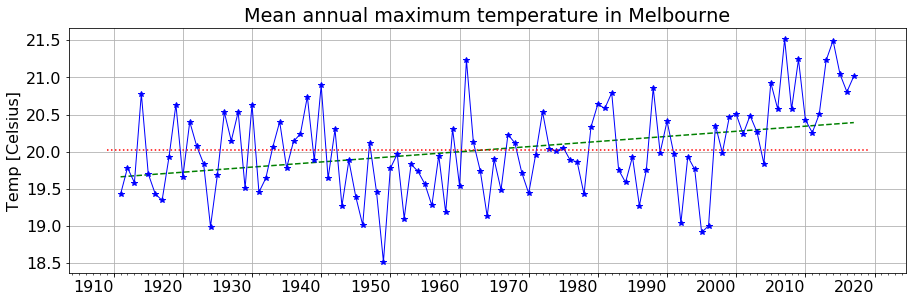

In [10]:
make_plot(yearly_tmax,dataset,'Mean annual maximum temperature in Melbourne',ylabel = 'Temp [' + dd1.tmax.units + ']',compare_line = tmax_mean.values,trend=True)

According to __[Australian Government Department of Environment and Energy](http://www.environment.gov.au/climate-change/climate-science-data/climate-science/impacts/vic)__ the average annual number of days above 35 degrees Celsius is likely to increase from 9 days currently experienced in Melbourne to up to 26 days by 2070 without global action to reduce emissions. 

We also found out that during a 100 years, on average of 9 days a year the temperature exceeds 35 $^o$C.

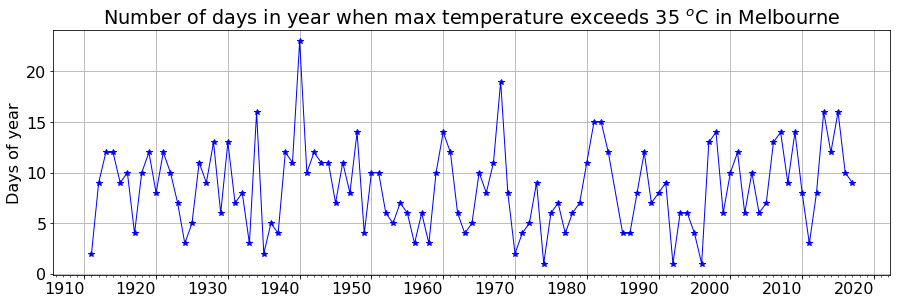

Yearly average days when temperature exceeds 35 C is 8.6


In [11]:
daily_data = dd1.tmax.resample('1D', dim='time', how='mean')[:,0,0]
make_plot(daily_data[np.where(daily_data.values > 35)].groupby('time.year').count(),dataset,'Number of days in year when max temperature exceeds 35 $^o$C in Melbourne',ylabel = 'Days of year')
print ('Yearly average days when temperature exceeds 35 C is ' + str("%.1f" % daily_data[np.where(daily_data.values > 35)].groupby('time.year').count().mean().values))

We saw that the maximum temperature tend to have similar pattern than ENSO.

Just as important as the change with the temperature is what has happened to the rainfall in Melbourne. To investigate that, we created an annual precipitation plot,  where a red line marks the average (623.7 mm). From the plot we can see that the average amount of rainfall has been constantly decreasing over the past century.

Less rainfall increases the risk of bushfires, impacts the agriculture in Melbourne and threatens its water reservoirs.

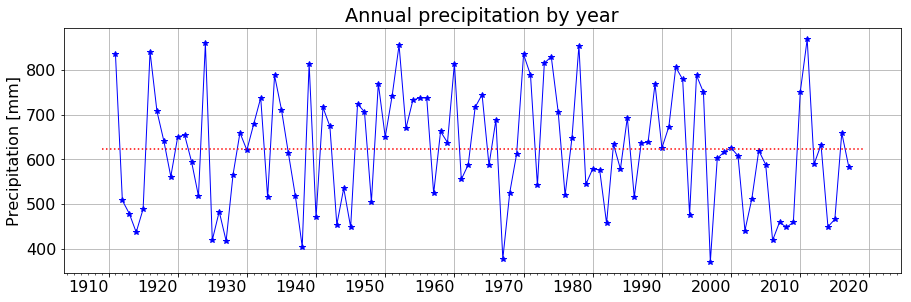

Mean overall rainfall (1911-2017) is 623.7 mm


In [12]:
mean_annual_prec = dd1.rain.resample('1AS', dim='time', how='sum').mean(axis=(0,1,2))
make_plot(dd1.rain.resample('1AS', dim='time', how='sum')[:,0,0],dataset,'Annual precipitation by year',ylabel='Precipitation [' + dd1.rain.units + ']',compare_line = mean_annual_prec)
print ('Mean overall rainfall (1911-2017) is ' + str("%.1f" % mean_annual_prec) + " mm") 

Alongside the decreased rainfall, the number of completely dry days in a year has changed as well. From the plot above, you can see that the number of days when it was completely dry in Melbourne grew in the 2000s. However, during the last years it has returned to normal. Again, marked with a green line is the trend that means that Melbourne is getting more and more completely dry days.

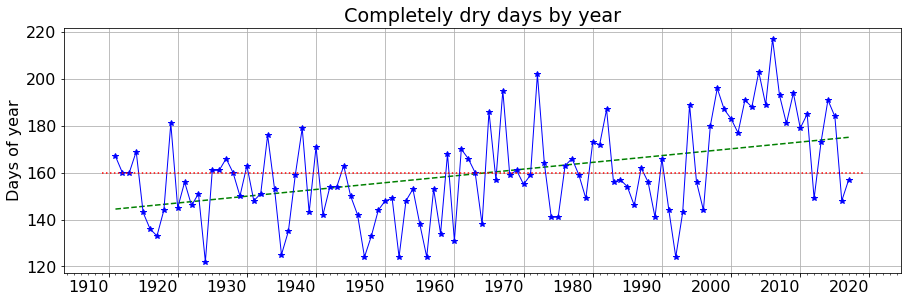

In [13]:
daily_rain = dd1.rain.resample('1D', dim='time', how='mean')[:,0,0]
make_plot(daily_rain[np.where(daily_rain.values < 0.00001)].groupby('time.year').count(),dataset,'Completely dry days by year',ylabel = 'Days of year',compare_line = daily_rain[np.where(daily_rain.values < 0.00001)].groupby('time.year').count().mean(),trend=True)